In [59]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [60]:
import pmdarima as pm

In [61]:
# imports time series
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# plots
import matplotlib.pyplot as plt
%matplotlib inline

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt


In [62]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"Statsmodels version {sm.__version__}")

Working with these versions of libraries

Numpy version 1.23.5
Pandas version 1.3.5
Statsmodels version 0.13.5


In [63]:
# Cargar datos agrupados a nivel semana
df_final = pd.read_csv('E:/Capstone-Retail/data_dsmarket/new_files/df_forecast_1.csv') #Marina Windows

## ARIMA (general)

In [64]:
df_all = df_final.groupby('date')['units'].sum().reset_index()
df_all.set_index('date', inplace=True)
df_all

,units
date,
2011-01-31,196230
2011-02-07,193715
2011-02-14,172328
2011-02-21,166645
2011-02-28,179283
...,...
2016-03-21,287458
2016-03-28,291571
2016-04-04,310767


In [65]:
# Leer el dataset de series de tiempo
ts = df_all.copy() 
ts.head()

,units
date,
2011-01-31,196230
2011-02-07,193715
2011-02-14,172328
2011-02-21,166645
2011-02-28,179283


In [66]:
# Eliminamos el 1r valor de la ts, ya que nos puede llevar a error.
# La primera semana hay menos ventas que el resto.
ts = ts.iloc[1:]

### 1. Verificar si la serie tiene estacionalidad y aplicar diferenciación estacional si es necesario

In [67]:
ts["units_log"] = ts["units"].apply(np.log)
ts["units_log_diff"] = ts["units_log"].diff() 
ts["units_log_diff_2"] = ts["units_log"].diff(2)
ts.head()

,units,units_log,units_log_diff,units_log_diff_2
date,,,,
2011-02-07,193715,12.174143,NaN,NaN
2011-02-14,172328,12.057155,-0.116988,NaN
2011-02-21,166645,12.023621,-0.033534,-0.150522
2011-02-28,179283,12.096721,0.073100,0.039566
2011-03-07,181714,12.110189,0.013468,0.086568


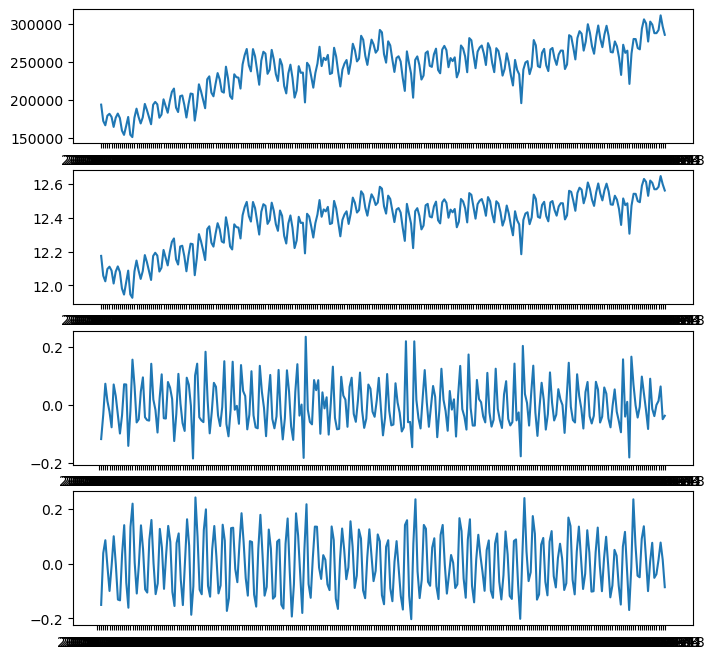

In [68]:
fig = plt.figure(figsize = (8, 8))
ax1, ax2, ax3, ax4  = fig.subplots(4, 1)

ax1.plot(ts["units"], label = "Original TS")
ax2.plot(ts["units_log"], label = "Log TS")
ax3.plot(ts["units_log_diff"], label = "Log Diff TS")
ax4.plot(ts["units_log_diff_2"], label = "Log Diff 2 TS")

##### Tests Estadísticos para comprobar la estacionalidad: Augmented Dickley-Fuller Test (ADF)

In [69]:
# Augmented Dickley-Fuller Test (ADF)
resultado_analisis = adfuller(ts["units"])

valor_estadistico_adf = round(resultado_analisis[0], 3)
p_valor = round(resultado_analisis[1], 3)
print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))

print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
print("p-valor: {}\n".format(p_valor))


Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -1.956

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.306



In [70]:
# Augmented Dickley-Fuller Test (Test adf)
resultado_analisis = adfuller(ts["units_log"])

valor_estadistico_adf = round(resultado_analisis[0], 3)
p_valor = round(resultado_analisis[1], 3)
print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))

print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
print("p-valor: {}\n".format(p_valor))

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -2.392

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.144



In [71]:
# Reemplazar valores infinitos con valores faltantes en la columna "units_log_diff"
ts["units_log_diff"] = ts["units_log_diff"].replace([np.inf, -np.inf], np.nan)

# Eliminar filas con valores faltantes en la columna "units_log_diff"
ts_clean = ts.dropna(subset=["units_log_diff"])

In [72]:
# Aplicar la prueba ADF a la columna "units_log_diff" de la serie temporal limpia
resultado_analisis = adfuller(ts_clean["units_log_diff"])

valor_estadistico_adf = round(resultado_analisis[0], 3)
p_valor = round(resultado_analisis[1], 3)

print("Valor estadístico de ADF de las tablas precalculadas: {}".format(-2.89))
print("Valor estadístico de ADF: {}\n".format(valor_estadistico_adf))

print("Nivel de significación para tomar la serie como estacionaria: {}".format(0.05))
print("p-valor: {}\n".format(p_valor))

Valor estadístico de ADF de las tablas precalculadas: -2.89
Valor estadístico de ADF: -4.273

Nivel de significación para tomar la serie como estacionaria: 0.05
p-valor: 0.0



Text(0.5, 0.98, 'Plots for Time Series Data and their transformations')

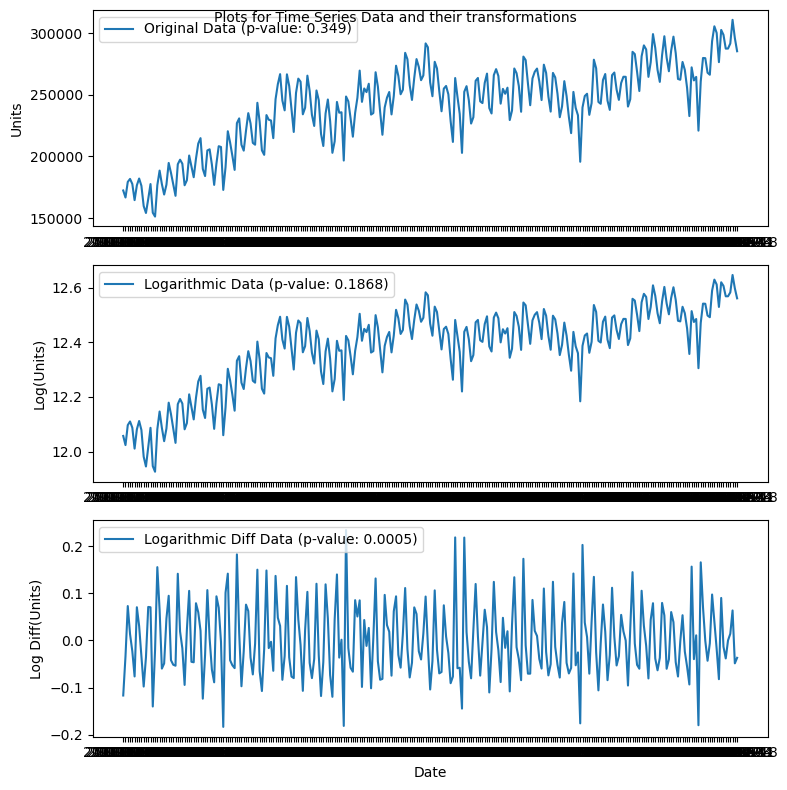

In [73]:
# Instantiate the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

# Select the data to plot
x = ts_clean.index
y = ts_clean["units"]
y_log = ts_clean["units_log"]
y_log_diff = ts_clean["units_log_diff"]

# Plot the original data
ax1.plot(x, y, label=f"Original Data (p-value: {round(adfuller(y)[1], 4)})")
ax1.set_ylabel("Units")
ax1.legend(loc="upper left")

# Plot the logarithmic data
ax2.plot(x, y_log, label=f"Logarithmic Data (p-value: {round(adfuller(y_log)[1], 4)})")
ax2.set_ylabel("Log(Units)")
ax2.legend(loc="upper left")

# Plot the cleaned logarithmic difference data
ax3.plot(x, y_log_diff, label=f"Logarithmic Diff Data (p-value: {round(adfuller(y_log_diff)[1], 4)})")
ax3.set_xlabel("Date")
ax3.set_ylabel("Log Diff(Units)")
ax3.legend(loc="upper left")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure title
fig.suptitle("Plots for Time Series Data and their transformations", fontsize=10)


* De los gráficos/tests estadísticos anteriores se desprende que solo podemos usar el "units_log_diff" para modelizar con el modelo de ARIMA(pqd), donde p-value <0.05.
* Tanto la serie original "units", como la "units_log" tienen un p-value > 0.05.

### 2. Determinar los posibles grados del modelo ARIMA(pdq)

##### Función de autocorrelación (ACF) y función de autocorrelación parcial (PACF)

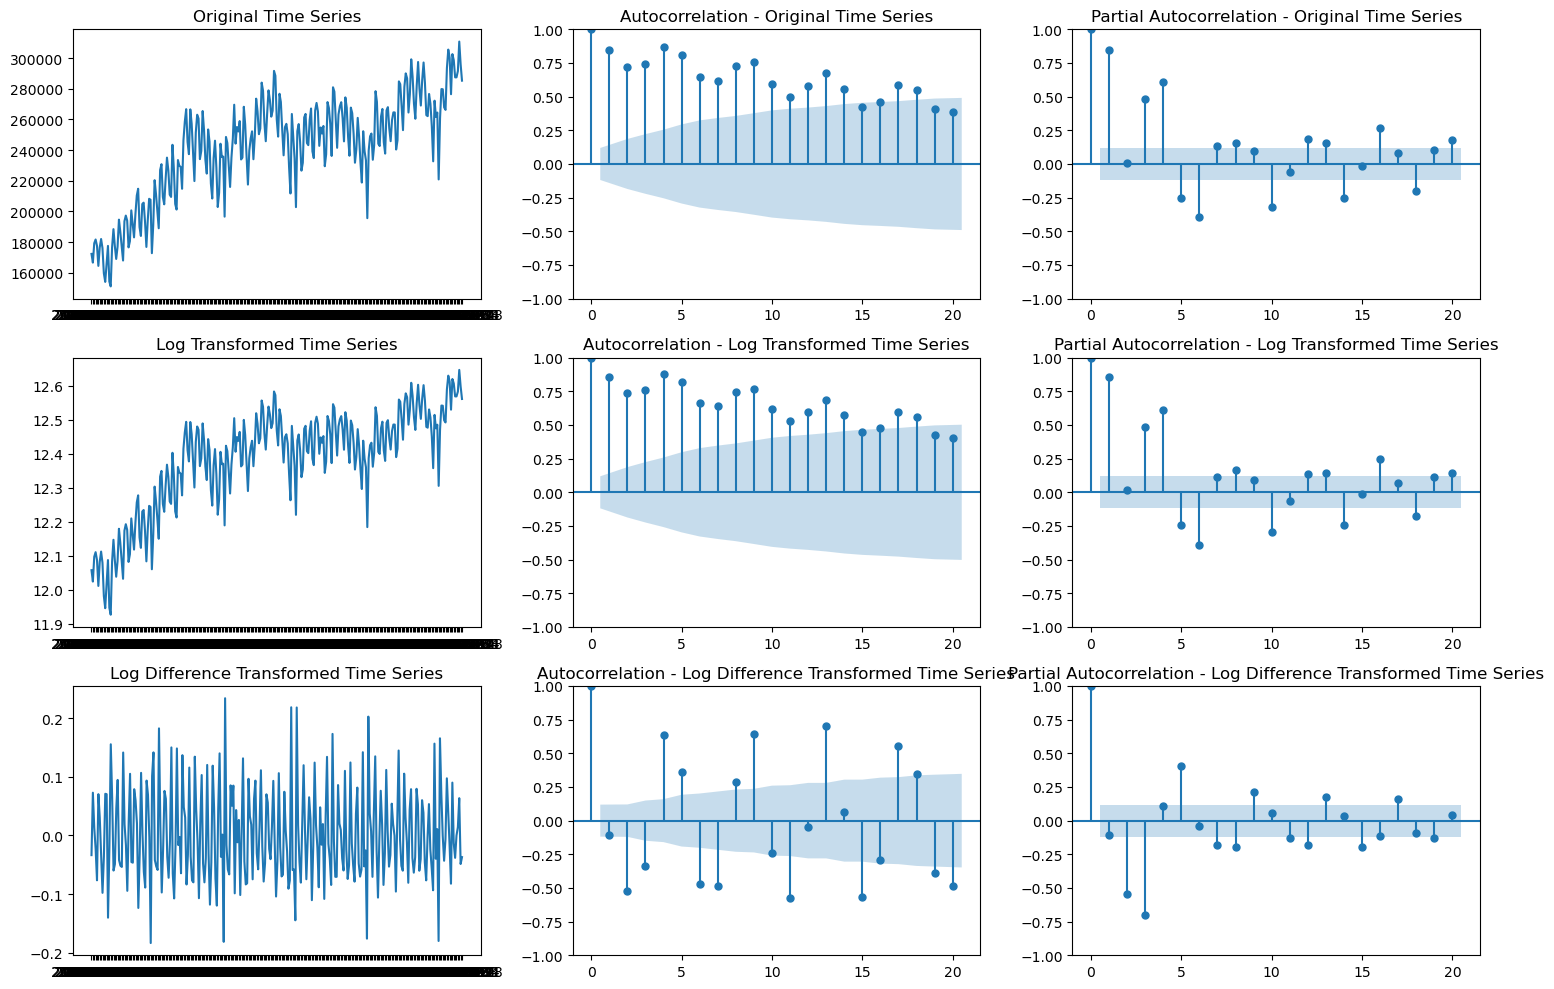

In [74]:
# Número de retrasos para los gráficos ACF y PACF
LAGS = 20

# Crear una nueva figura y los subplots para ACF y PACF
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Select the data to plot
x = ts_clean.index
y = ts_clean["units"]
y_log = ts_clean["units_log"]
y_log_diff = ts_clean["units_log_diff"]

# Serie Original
axes[0, 0].plot(x, y)
axes[0, 0].set_title("Original Time Series")
plot_acf(y, ax=axes[0, 1], lags=LAGS, title="Autocorrelation - Original Time Series")
plot_pacf(y, ax=axes[0, 2], lags=LAGS, title="Partial Autocorrelation - Original Time Series")

# Serie Logarítmica
axes[1, 0].plot(x, y_log)
axes[1, 0].set_title("Log Transformed Time Series")
plot_acf(y_log, ax=axes[1, 1], lags=LAGS, title="Autocorrelation - Log Transformed Time Series")
plot_pacf(y_log, ax=axes[1, 2], lags=LAGS, title="Partial Autocorrelation - Log Transformed Time Series")

# Serie Logarítmica Diferenciada
axes[2, 0].plot(x[1::], y_log_diff[1:]) #al calcular la diferencia, se pierde el primer valor de la serie original
axes[2, 0].set_title("Log Difference Transformed Time Series")
plot_acf(y_log_diff, ax=axes[2, 1], lags=LAGS, title="Autocorrelation - Log Difference Transformed Time Series")
plot_pacf(y_log_diff, ax=axes[2, 2], lags=LAGS, title="Partial Autocorrelation - Log Difference Transformed Time Series")

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

¿Como puedo interpretar yo los dos gráficos anteriores?

1. **Gráfico de Autocorrelación (ACF)**: muestra la correlación de Pearson entre la serie y la serie “laggeada” (valores anteriores de la serie). Este gráfico nos permite determinar cuál es el grado q de la parte **MA(q)**.
2. **Gráfico de Autocorrelación Parcial (PACF)**: muestra la fuerza entre la serie y valores anteriores eliminando cualquier impacto intermedio. Yt viene “influyenciado” por el valor en Yt-1, Yt-1 a su vez viene influyenciado por Yt-2. Por tanto, el gráfico de autocorrelación parcial viene a decir: que impacto tiene en Yt, Yt-2 si eliminamos el impacto en Yt de Yt-1. Por tanto vemos el impacto “directo” de Yt2 a Yt. Nos ayuda a determinar el valor de **AR(p)** en un modelo ARIMA. 


Los valores fuera del área sombreada son valores estadísticamente significativos y pueden servir para modelizar mi serie temporal. En este momento del proceso de modelización “estamos acotando” posibles modelos que vamos a validar ya que a priori no sabemos cuál puede funcionar mejor.

#### Gridsearch junto con AIC para determinar los posibles parametros del modelo

* AR(p): es la parte autoregresiva del modelo
* I(d): es el número de diferenciaciones que hemos hemos a la Serie Temporal.
* MA(q): es la parte de medias móviles del modelo

In [75]:
def get_param_combinations(p_values, d_values, q_values):
    """
    Genera todas las combinaciones posibles de parámetros para ARIMA y SARIMA.
    Args:
        p_values (list): Lista de valores para el parámetro p de ARIMA.
        d_values (list): Lista de valores para el parámetro d de ARIMA.
        q_values (list): Lista de valores para el parámetro q de ARIMA.
    Returns:
        list: Lista de tuplas con todas las combinaciones posibles de parámetros.
    """
    param_combinations = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                param_combinations.append((p, d, q))
    return param_combinations

# Definir los valores posibles para los parámetros p, d, q
p_values = [3, 4]
d_values = [0, 1, 2]
q_values = [2, 3, 4]

# Obtener todas las combinaciones posibles de parámetros
param_combinations = get_param_combinations(p_values, d_values, q_values)

# Imprimir las combinaciones de parámetros
for params in param_combinations:
    print(params)

(3, 0, 2)
(3, 0, 3)
(3, 0, 4)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(3, 2, 2)
(3, 2, 3)
(3, 2, 4)
(4, 0, 2)
(4, 0, 3)
(4, 0, 4)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)
(4, 2, 2)
(4, 2, 3)
(4, 2, 4)


In [76]:
ts_to_predict_arima = ts["units_log"]
ts_to_predict_arima

date
2011-02-07    12.174143
2011-02-14    12.057155
2011-02-21    12.023621
2011-02-28    12.096721
2011-03-07    12.110189
                ...    
2016-03-21    12.568832
2016-03-28    12.583039
2016-04-04    12.646799
2016-04-11    12.598145
2016-04-18    12.561223
Name: units_log, Length: 272, dtype: float64

In [77]:
y_train_arima = ts_to_predict_arima[:-4]
y_train_arima

date
2011-02-07    12.174143
2011-02-14    12.057155
2011-02-21    12.023621
2011-02-28    12.096721
2011-03-07    12.110189
                ...    
2016-02-22    12.529760
2016-02-29    12.620091
2016-03-07    12.606884
2016-03-14    12.568717
2016-03-21    12.568832
Name: units_log, Length: 268, dtype: float64

In [78]:
y_test_arima = ts_to_predict_arima[-4:]
y_test_arima

date
2016-03-28    12.583039
2016-04-04    12.646799
2016-04-11    12.598145
2016-04-18    12.561223
Name: units_log, dtype: float64

In [79]:
# Diccionario para almacenar los resultados
RESULTS_DICT = {}

# Iterar sobre todas las combinaciones de parámetros
for params in param_combinations:
    model = sm.tsa.statespace.SARIMAX(
        endog=y_train_arima,
        order=params[:3],  # Parámetros ARIMA
        seasonal_order=(0, 0, 0, 0),  # Sin componente estacional
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fitted = model.fit()
    aic = model_fitted.aic
    print(f"ARIMA{params[:3]}x(0, 0, 0, 0) - AIC: {aic}")
    RESULTS_DICT[params] = round(aic, 2)

ARIMA(3, 0, 2)x(0, 0, 0, 0) - AIC: -836.6151118714826
ARIMA(3, 0, 3)x(0, 0, 0, 0) - AIC: -902.1308377626353
ARIMA(3, 0, 4)x(0, 0, 0, 0) - AIC: -919.347590801323
ARIMA(3, 1, 2)x(0, 0, 0, 0) - AIC: -940.4654183798284
ARIMA(3, 1, 3)x(0, 0, 0, 0) - AIC: -934.7884060742697
ARIMA(3, 1, 4)x(0, 0, 0, 0) - AIC: -931.0825524245844
ARIMA(3, 2, 2)x(0, 0, 0, 0) - AIC: -832.6578075667903
ARIMA(3, 2, 3)x(0, 0, 0, 0) - AIC: -928.497296774587
ARIMA(3, 2, 4)x(0, 0, 0, 0) - AIC: -920.0306298709324
ARIMA(4, 0, 2)x(0, 0, 0, 0) - AIC: -935.5162805120342
ARIMA(4, 0, 3)x(0, 0, 0, 0) - AIC: -934.9383285669497
ARIMA(4, 0, 4)x(0, 0, 0, 0) - AIC: -933.5994956226801
ARIMA(4, 1, 2)x(0, 0, 0, 0) - AIC: -822.3901852974034
ARIMA(4, 1, 3)x(0, 0, 0, 0) - AIC: -933.4103827865724
ARIMA(4, 1, 4)x(0, 0, 0, 0) - AIC: -928.5873822591954
ARIMA(4, 2, 2)x(0, 0, 0, 0) - AIC: -845.6958736305702
ARIMA(4, 2, 3)x(0, 0, 0, 0) - AIC: -894.759349648341
ARIMA(4, 2, 4)x(0, 0, 0, 0) - AIC: -921.1232527929515


In [80]:
# gridsearch x y gridsearch y
gsx = list(map(str, list(RESULTS_DICT.keys())))
gsy = list(RESULTS_DICT.values())

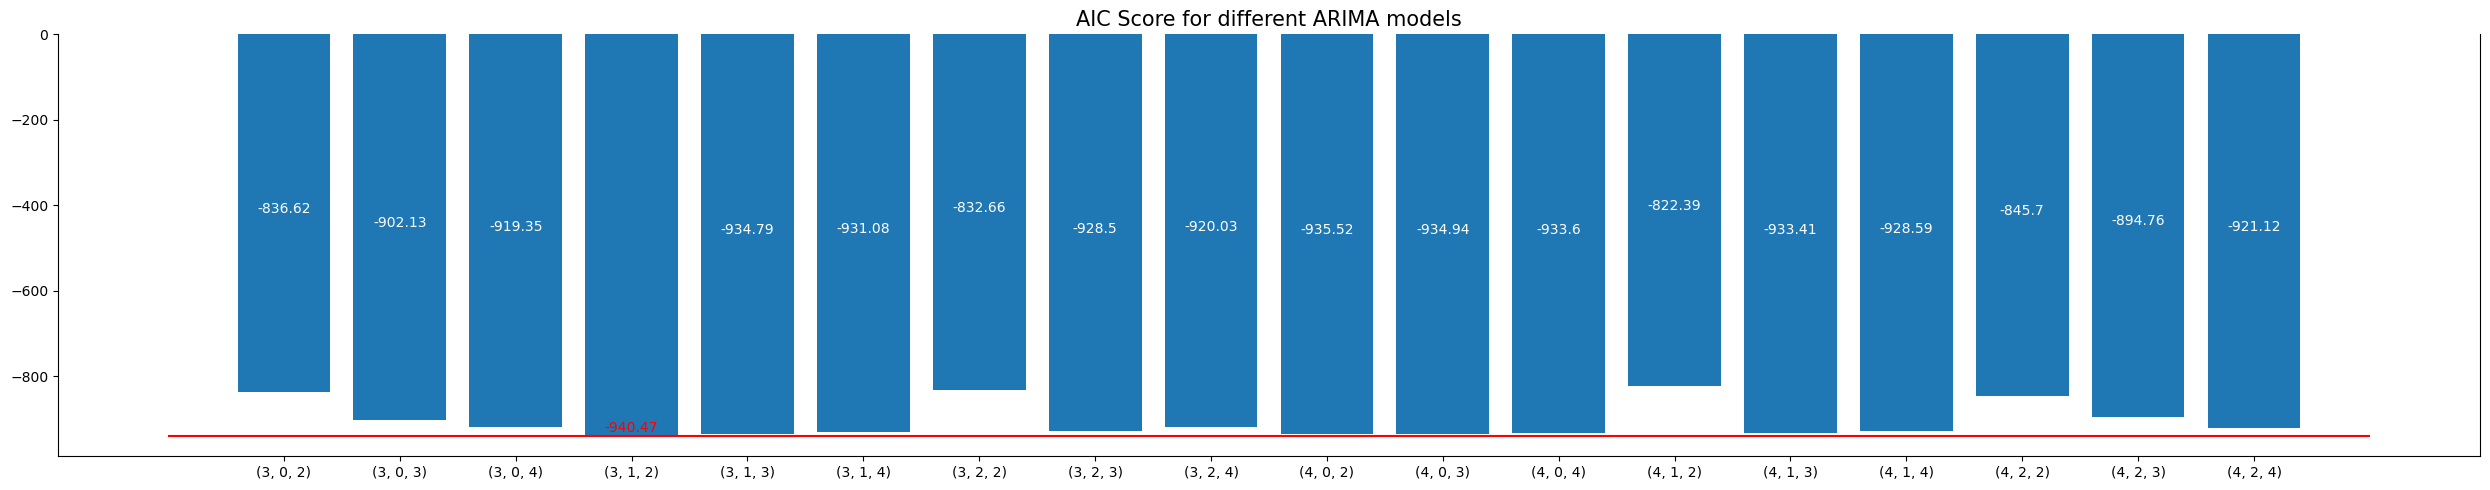

In [81]:
fig = plt.figure(figsize = (25, 5))
ax = fig.add_subplot()

ax.bar(x = gsx, height = gsy)
ax.hlines(y = min(gsy), xmin = -1, xmax = len(gsx), color = "red")

for xtick_, y_ in zip(gsx, gsy):
    
    s_ = str(round(y_, 2))
    
    ax.text(
        x = xtick_, 
        y = y_/2 if y_ != min(gsy) else y_ + 10, 
        s = s_, 
        ha = "center", 
        color = "red" if y_ == min(gsy) else "white"
    )

ax.spines["top"].set_color("None")

plt.title(label = "AIC Score for different ARIMA models", fontsize = 15)
plt.tight_layout()

In [82]:
idx_min_score_aic = np.argmin(list(RESULTS_DICT.values()))
pdq_min_score_aic = list(RESULTS_DICT.keys())[idx_min_score_aic]
min_score_aic = RESULTS_DICT[pdq_min_score_aic]

message = f'''
El score mínimo se alcanza con ARIMA{pdq_min_score_aic}
Con un score AIC de {min_score_aic}.
En la posición {idx_min_score_aic}
'''

print(message)


El score mínimo se alcanza con ARIMA(3, 1, 2)
Con un score AIC de -940.47.
En la posición 3



### 3. Fit del modelo ARIMA(pdq)
Una vez que tengo los grados del modelo, puedo pasar a estimar los coeficientes de mi modelo (phi y theta).

In [83]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = y_train_arima,
    order = pdq_min_score_aic,
    seasonal_order=(0, 0, 0, 0),  # Sin componente estacional
    enforce_stationarity=False,
    enforce_invertibility=False
)

best_arima_model_fitted = best_arima_model.fit()
print(best_arima_model_fitted.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3286      0.046     -7.119      0.000      -0.419      -0.238
ar.L2         -0.8536      0.012    -72.344      0.000      -0.877      -0.830
ar.L3         -0.5781      0.046    -12.590      0.000      -0.668      -0.488
ma.L1         -0.2382      0.114     -2.093      0.036      -0.461      -0.015
ma.L2          0.9995      0.972      1.028      0.304      -0.905       2.904
sigma2         0.0015      0.001      1.051      0.293      -0.001       0.004


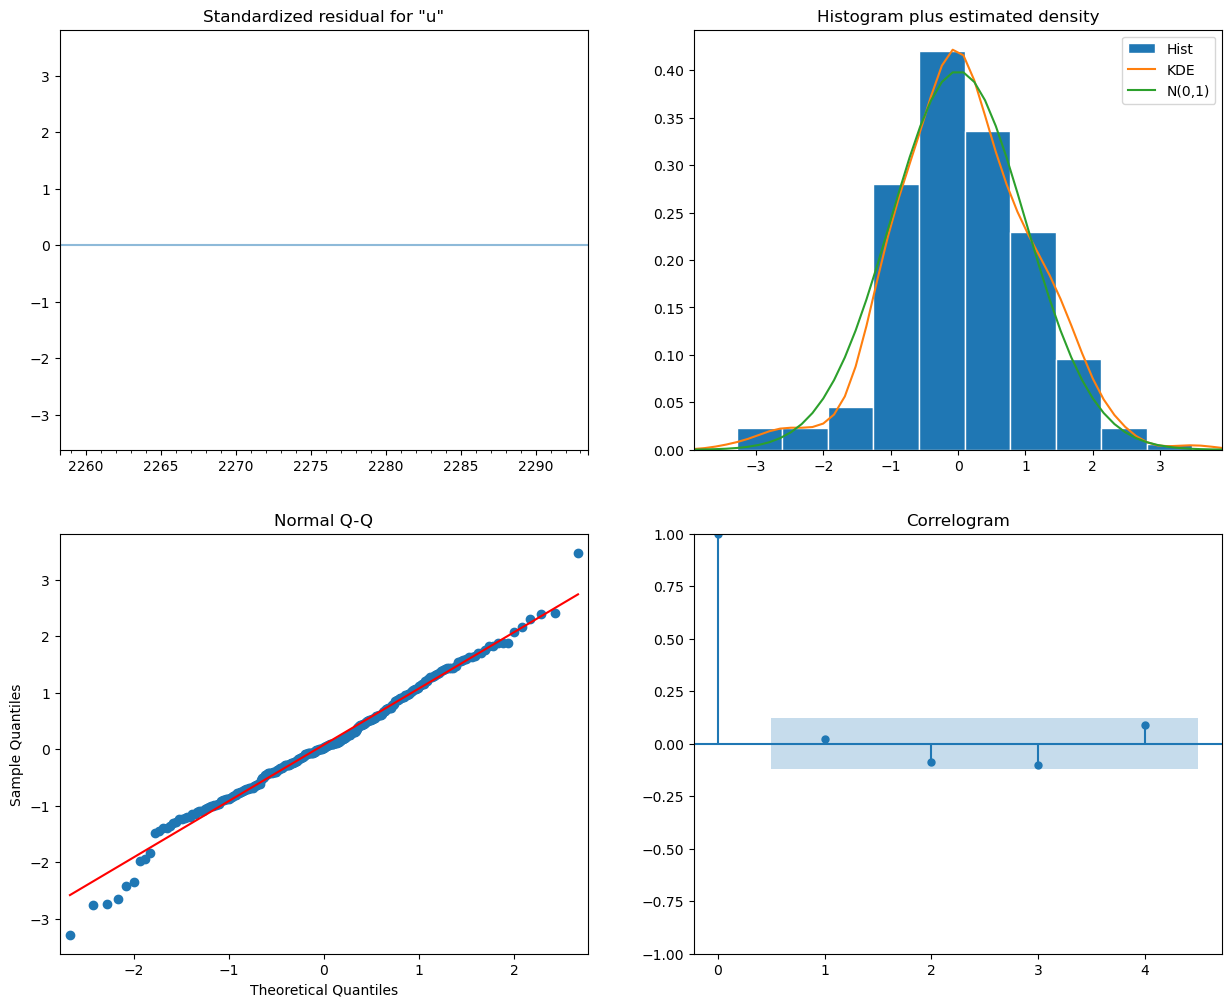

In [84]:
best_arima_model_fitted.plot_diagnostics(figsize = (15, 12), lags = 4);

Mirando los gráficos podemos observar lo siguiente:

* **Arriba a la izquiera**: los residuos del modelo parece que siguen un proceso de Ruido Blanco (White Noise) y no son predecibles. Esto implica que nuestro modelo ha extraído toda la información de los datos.
* **Arriba a la derecha**: vemos que la distribución de los residuos sigue una distribución próxima a la Normal (0, 1).
* **Abajo a la derecha**: vemos que la autocorrelación parcial entre los residuos y residuos - k periodos atrás, dan lugar a valores no significativos. Esto implica que no "nos queda" información a extraer de los residuos.
* **Abajo a la izquierda**: la distribución ordenada de los residuos sigue una Normal.

#### Funciona el autoarima igual que nuestras predicciones?

In [85]:
from pmdarima import auto_arima

In [86]:
model = auto_arima(y_log, trace=False, error_action='ignore', suppress_warnings=True)
model.fit(y_log)

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### 4. Realizar predicciones de ventas para el próximo mes

Con los modelos ARIMA generados y ajustados, podemos hacer predicciones de ventas para el próximo mes (28 días).

In [87]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = best_arima_model_fitted.get_forecast(steps = len(y_test_arima))
y_pred_arima = pred_uc.predicted_mean

y_pred_arima

2016-03-28    12.585373
2016-04-04    12.675446
2016-04-11    12.631664
2016-04-18    12.559600
Freq: W-MON, Name: predicted_mean, dtype: float64

In [88]:
# Format the datetime index as "year-month-day"
y_pred_arima.index = y_pred_arima.index.strftime("%Y-%m-%d")

y_pred_arima

2016-03-28    12.585373
2016-04-04    12.675446
2016-04-11    12.631664
2016-04-18    12.559600
Name: predicted_mean, dtype: float64

In [89]:
# Apply exponential function to reverse logarithmic transformation
ts_to_predict_arima_exp = np.exp(ts_to_predict_arima)
y_pred_arima_exp = np.exp(y_pred_arima)

In [112]:
# Tomar los últimos 4 valores de ts["units"]
last_4_values = ts["units"][-4:]

# Calcular las métricas con los últimos 4 valores
mse_arima_forecast = np.mean((last_4_values - y_pred_arima_exp) ** 2)
rmse_arima_forecast = np.sqrt(mse_arima_forecast)
mae_arima_forecast = np.mean(np.abs(last_4_values - y_pred_arima_exp))
mape_arima_forecast = np.mean(np.abs((last_4_values - y_pred_arima_exp) / last_4_values)) * 100

print("MSE ARIMA Forecast:", mse_arima_forecast)
print("RMSE Manual SES:", rmse_arima_forecast)
print("MAE ARIMA Forecast:", mae_arima_forecast)
print("MAPE ARIMA Forecast:", mape_arima_forecast)

MSE ARIMA Forecast: 46013233.43875274
RMSE Manual SES: 6783.305495018836
MAE ARIMA Forecast: 5066.348068762352
MAPE ARIMA Forecast: 1.677674674293116


Text(0.5, 0.98, 'Lynx Values and ARIMA Forecast')

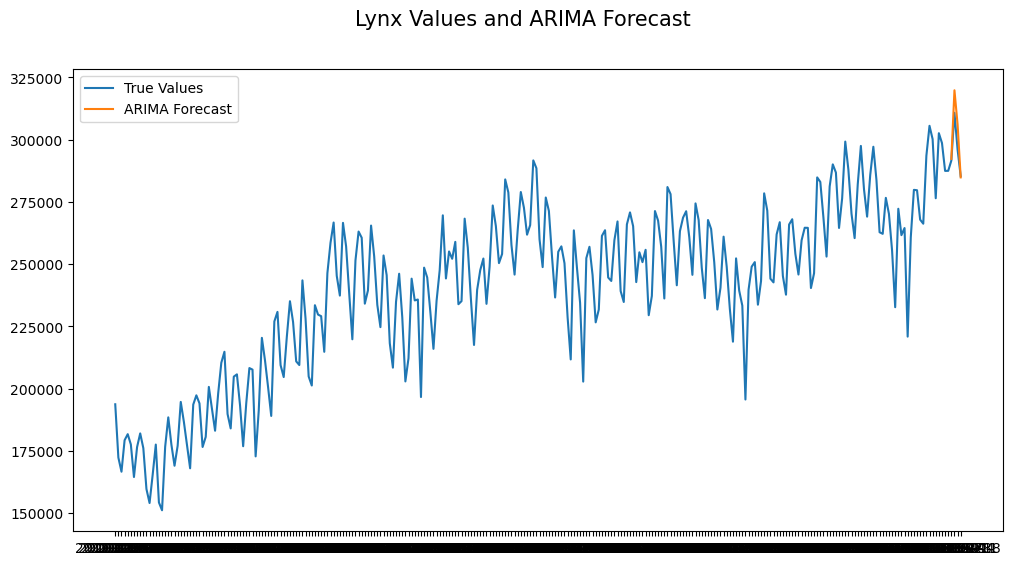

In [113]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(ts_to_predict_arima_exp, label = "True Values")
ax.plot(y_pred_arima_exp, label = "ARIMA Forecast")

ax.legend(loc = "upper left")
fig.suptitle("Lynx Values and ARIMA Forecast", fontsize = 15)

## Exponential Smoothing (general)

𝑦̂𝑥 = 𝛼⋅𝑦𝑥+(1−𝛼)⋅𝑦̂𝑥−1

Donde:

𝑦̂𝑥: es nuestra estimación para el periodo x.

𝛼: alpha es el coeficiente modelo y viene a ser el peso que le vamos a dar cada valor.

𝑦𝑥: es el valor observado en el periodo x.

𝑦̂𝑥-1: es la estimación para el periodo x - 1

Si nos fijamos de manera detenida en la fórmula anterior vemos que es recursiva. Es decir, 𝑦̂𝑥 depende en (1 - 𝛼) de 𝑦̂𝑥-1. 𝑦̂𝑥-1 a su vez depende de 𝑦̂𝑥-2. Además, según esta ecuación, conforme más nos alejammos al pasado, menos influencia van a tener estos valores.

Por tanto, si alpha es elevado: los valores del presente van a tener mayor importancia y viceversa.

In [92]:
def simple_exponential_smoothing_forecast(series, alpha):
    '''
    Implements the simple exponential smoothing forecasting method.
    '''
    result = [series[0]] # creamos una lista vacía
    
    for value in series[1:]:
        result.append((alpha * value) + ((1 - alpha) * result[-1]))
        
    return result

In [93]:
# lo convertimos en una lista
ts_list = ts[:-4]["units"].tolist()
ts_list

[193715,
 172328,
 166645,
 179283,
 181714,
 177597,
 164513,
 176545,
 182025,
 176125,
 159691,
 154072,
 165448,
 177537,
 154287,
 151152,
 176634,
 188462,
 177514,
 169040,
 177030,
 194662,
 186668,
 177274,
 168009,
 193591,
 197309,
 194069,
 176567,
 180622,
 200693,
 191793,
 183097,
 198162,
 210403,
 214796,
 189794,
 184029,
 204814,
 205730,
 193321,
 176866,
 194253,
 208254,
 207633,
 172791,
 191225,
 220394,
 211342,
 200486,
 189034,
 226986,
 230819,
 209412,
 204654,
 220850,
 235095,
 226743,
 210949,
 209471,
 243471,
 228127,
 204877,
 201244,
 233506,
 229733,
 229095,
 214782,
 246368,
 258576,
 266697,
 245295,
 237358,
 266563,
 257125,
 238116,
 219810,
 251490,
 263071,
 260586,
 234119,
 239427,
 265475,
 253106,
 233643,
 224691,
 253466,
 245567,
 218212,
 208427,
 234825,
 246134,
 228702,
 202892,
 212203,
 244157,
 235419,
 235783,
 196621,
 248571,
 244623,
 230807,
 215976,
 235285,
 247569,
 269588,
 244231,
 255076,
 252140,
 258928,
 233896,
 

In [94]:
ses = SimpleExpSmoothing(endog = ts_list)
ses_fitted = ses.fit()
ses_fitted.params

{'smoothing_level': 0.2812790697674419,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 193715.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [95]:
# Get the forecasted values for the last 4 data points
ses_forecasted_values = ses_fitted.forecast(steps=4)

ses_forecasted_values

array([289892.9597198, 289892.9597198, 289892.9597198, 289892.9597198])

In [96]:
# Calcular las métricas con los últimos 4 valores
mse_manual_ses = np.mean((last_4_values - ses_forecasted_values) ** 2)
rmse_manual_ses = np.sqrt(mse_manual_ses)
mae_manual_ses = np.mean(np.abs(last_4_values - ses_forecasted_values))
mape_manual_ses = np.mean(np.abs((last_4_values - ses_forecasted_values) / last_4_values)) * 100

print("MSE Manual SES:", mse_manual_ses)
print("RMSE Manual SES:", rmse_manual_ses)
print("MAE Manual SES:", mae_manual_ses)
print("MAPE Manual SES :", mape_manual_ses)

MSE Manual SES: 124308987.4516217
RMSE Manual SES: 11149.394039660707
MAE Manual SES: 8320.520140101406
MAPE Manual SES : 2.743994041787221


In [97]:
manual_ses_series = pd.Series(data = ses_forecasted_values, index = ts[-4:].index)
# Convert the index of ts_fitted_forecasted to datetime with a specific format
manual_ses_series.index = pd.to_datetime(manual_ses_series.index).strftime('%Y-%m-%d')
manual_ses_series

date
2016-03-28    289892.95972
2016-04-04    289892.95972
2016-04-11    289892.95972
2016-04-18    289892.95972
dtype: float64

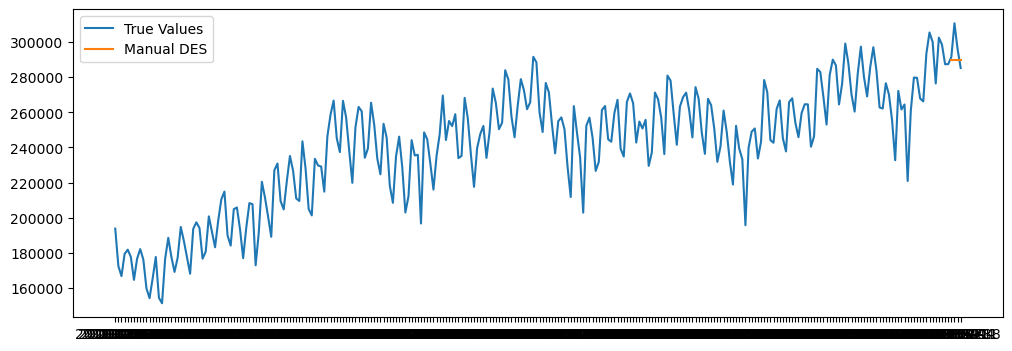

In [98]:
# Plot the adjusted series
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot()

ax.plot(ts["units"], label = "True Values")
ax.plot(manual_ses_series, label = "Manual DES")

plt.legend()
plt.show()

## Double Exponential Smoothing (DES) (general)

Value = ℓ𝑥 = 𝛼𝑦𝑥+(1−𝛼)(ℓ𝑥−1+𝑇𝑥−1)

Trend = 𝑇𝑥 = 𝛽(ℓ𝑥−ℓ𝑥−1)+(1−𝛽)𝑇𝑥−1 x

Forecast = 𝑦̂𝑥+1= ℓ𝑥 + 𝑇𝑥

𝑦̂𝑥+1 es el resultado de Value (de hecho en Simple Exponential Smoothing es el 𝑦̂𝑥, pero ahora no podemos llamarlo 𝑦̂𝑥 porque habitualmente 𝑦̂𝑥 se reserva a las predicciones y Value es un input del Forecast) y Trend.

In [99]:
def double_exponential_smoothing_forecast(series, alpha, beta, n_preds):
    '''
    Implements the double exponential smoothing forecast
    '''
    len_series = len(series)
    
    level = series[0] # primera predicción es el primer valor de la ts
    trend = series[1] - level # pendiente de la serie temporal (diff entre los dos primeros puntos observados)
    
    result = [level] # creamos una lista con nuestros futuros forecasts
    
    for i in range(1, len_series + 1): # + 1 para llegar al final de nuestro serie temporal
        
        if i < len_series: # mientras ajustamos la serie "real"
            value = series[i]
            
        else:
            # cuando vamos a querer hacer el forecasting, el value será nuestro último ajuste a la serie real
            value = result[-1]
            
        # hacemos el swap
        previous_level = level
        level = ((alpha * value) + ((1 - alpha) * (level + trend)))
        
        trend = ((beta * (level - previous_level)) + ((1 - beta) * trend))
        
        yhat = round((level + trend), 3)
        
        result.append(yhat)
        
    # la predicción a futuro
    if n_preds > 1:
        for n_pred in range(2, n_preds + 1):
            yhat = round((level + (n_pred * trend)), 3)
            result.append(yhat)
            
    return result

In [100]:
manual_desf = double_exponential_smoothing_forecast(
    series = ts_list, 
    alpha = 0.9, 
    beta = 0.9, 
    n_preds = 4
)

In [101]:
manual_desf_series = pd.Series(data = manual_desf, index = ts.index)
# Convert the index of ts_fitted_forecasted to datetime with a specific format
manual_desf_series.index = pd.to_datetime(manual_desf_series.index).strftime('%Y-%m-%d')
manual_desf_series

date
2011-02-07    193715.000
2011-02-14    150941.000
2011-02-21    156407.840
2011-02-28    186857.604
2011-03-07    187924.161
                 ...    
2016-03-21    283561.352
2016-03-28    280469.555
2016-04-04    277377.759
2016-04-11    274285.963
2016-04-18    271194.166
Length: 272, dtype: float64

In [102]:
# manual_desf_series contiene las predicciones del modelo Manual DES
manual_desf_series_last_4 = manual_desf_series[-4:]

# Calcular las métricas con los últimos 4 valores
mse_manual_des = np.mean((last_4_values - manual_desf_series_last_4) ** 2)
rmse_manual_des = np.sqrt(mse_manual_des)
mae_manual_des = np.mean(np.abs(last_4_values - manual_desf_series_last_4))
mape_manual_des = np.mean(np.abs((last_4_values - manual_desf_series_last_4) / last_4_values)) * 100

print("MSE Manual DES:", mse_manual_des)
print("RMSE Manual DES:", rmse_manual_des)
print("MAE Manual DES:", mae_manual_des)
print("MAPE Manual DES :", mape_manual_des)

MSE Manual DES: 477089095.2387574
RMSE Manual DES: 21842.369267979087
MAE Manual DES: 20074.639249999993
MAPE Manual DES : 6.706863211158827


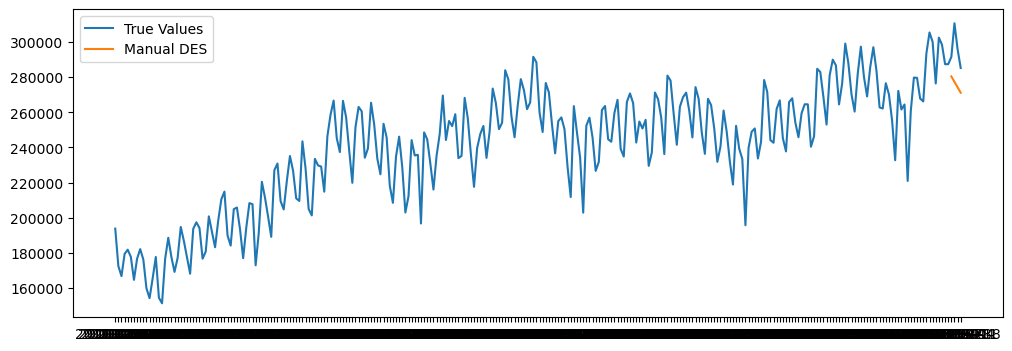

In [103]:
# Plot the adjusted series
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot()

ax.plot(ts["units"], label = "True Values")
ax.plot(manual_desf_series_last_4, label = "Manual DES")

plt.legend()
plt.show()

## Triple Exponential Smoothing (TES) o Holt Winters (general)

Se trata de ampliar la formula anterior añadiendo la parte de Seasonal a la ecuación.

Level = ℓ𝑥 = 𝛼(𝑦𝑥−𝑆𝑥−𝐿)+(1−𝛼)(ℓ𝑥−1+𝑇𝑥−1)

Trend = 𝑇𝑥 = 𝛽(ℓ𝑥−ℓ𝑥−1)+(1−𝛽)𝑇𝑥−1

Seasonal = 𝑆𝑥 = 𝛾(𝑦𝑥−ℓ𝑥)+(1−𝛾)𝑠𝑥−𝐿

Forecast = 𝑦̂𝑥+𝑚= ℓ𝑥+𝑚𝑇𝑥+𝑆𝑥−𝐿+1+(m-1)mod L

Nota: en todo momento hemos hablado de Series Temporales que tengan un Trend Aditivo (por ejemplo aumentan en 10k€ en cada periodo). 
Existen Series Temporales que tienen un Trend Multiplicativo (aumentan cada periodo un 10%). El modelo de Holt Winters se puede adaptar para Series Temporales con Trends Multiplicativos.

In [104]:
# Definir los parámetros de búsqueda del HoltWinters
param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'seasonal_periods': [2, 3, 4, 5], # ojo que debemos saber nuestros periodos. Hay que visualizar la TS y determinarlo
}

In [105]:
best_score = np.inf
best_params = None

# Convert the last index value to datetime
last_index = datetime.strptime(ts[:-4].index[-1], "%Y-%m-%d")
start_date = (last_index + timedelta(weeks=1)).strftime("%Y-%m-%d")
end_date = (last_index + timedelta(weeks=4)).strftime("%Y-%m-%d")

In [106]:
# Loop over the parameter grid
for trend in param_grid["trend"]:
    for seasonal in param_grid["seasonal"]:
        for seasonal_periods in param_grid["seasonal_periods"]:
            # Fit the Holt-Winters model with the current parameters
            hw_model = ExponentialSmoothing(endog = ts[:-4]["units"], 
                                            trend = trend, 
                                            seasonal = seasonal,
                                            seasonal_periods = seasonal_periods
                                            ).fit()

            # Make predictions
            predictions = hw_model.predict(start=start_date, end=end_date)

            # Calculate the mean squared error
            mse = mean_squared_error(ts[-4:]["units"], predictions)
            rmse = np.sqrt(mse)

            # Update the best score and parameters if the current score is better
            if rmse < best_score:
                best_score = rmse
                best_params = {"trend": trend, 
                               "seasonal": seasonal, 
                               "seasonal_periods" : seasonal_periods}

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best score:", best_score)

Best parameters: {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 4}
Best score: 8388.119459046053


In [107]:
# Definir el modelo Holt-Winters con los mejores parámetros
best_hw_model = ExponentialSmoothing(endog = ts[:-4]["units"],
                                     trend = "mul",
                                     seasonal = "mul",
                                     seasonal_periods = 4)

In [108]:
hw_model_fitted = best_hw_model.fit() #incorporar el mejor modelo
hw_model_fittedvalues = hw_model_fitted.fittedvalues

ts["units_fitted"] = hw_model_fittedvalues

hw_model_forecast4 = hw_model_fitted.forecast(steps = 4)
# Convert the index of ts_fitted_forecasted to datetime with a specific format
hw_model_forecast4.index = pd.to_datetime(hw_model_forecast4.index).strftime('%Y-%m-%d')
hw_model_forecast4

2016-03-28    302660.105254
2016-04-04    300706.585555
2016-04-11    291365.304980
2016-04-18    278405.984112
dtype: float64

In [109]:
best_hw_model.params

{'smoothing_level': 0.14642857142857144,
 'smoothing_trend': 0.026623376623376625,
 'smoothing_seasonal': 0.8535714285714285,
 'damping_trend': nan,
 'initial_level': 179886.9999999999,
 'initial_trend': 0.9929017939039508,
 'initial_seasons': array([1.03107738, 1.05216473, 0.94733811, 0.96941978]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [110]:
# Calcular las métricas con los últimos 4 valores
mse_hw_forecast = np.mean((last_4_values - hw_model_forecast4) ** 2)
rmse_hw_forecast = np.sqrt(mse_hw_forecast)
mae_hw_forecast = np.mean(np.abs(last_4_values - hw_model_forecast4))
mape_hw_forecast = np.mean(np.abs((last_4_values - hw_model_forecast4) / last_4_values)) * 100

print("MSE Holt Winters Forecast:", mse_hw_forecast)
print("RMSE Holt Winters Forecast:", rmse_hw_forecast)
print("MAE Holt Winters Forecast:", mae_hw_forecast)
print("MAPE Holt Winters Forecast:", mape_hw_forecast)

MSE Holt Winters Forecast: 73245611.24025859
RMSE Holt Winters Forecast: 8558.36498638955
MAE Holt Winters Forecast: 8166.557651508891
MAPE Holt Winters Forecast: 2.754626479181963


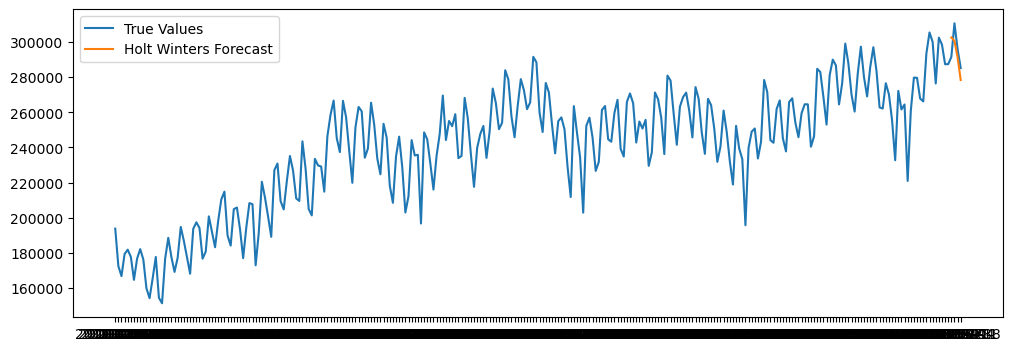

In [111]:
# Plot the adjusted series
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot()

ax.plot(ts["units"], label = "True Values")
ax.plot(hw_model_forecast4, label = "Holt Winters Forecast")

plt.legend()
plt.show()